In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import seaborn as sns
#from warnings import filterwarnings
#filterwarnings('ignore')

Analysis per Tier:

-	Number of active SP
-	Number of average orders per year
-	Average Basket Value
-	Frequency
-	Average Sales
-	CM1 
-	CM2
-	Share of Proplan Sales per Tier
-	Share of Orders with Proplan per Tier
-	Repurchasing rate within specific time period per Tier

#### Data loading and processing

In [2]:
data = pd.read_csv('pro_plan_sp_orders_jul17_jun18.dsv', sep=';', low_memory=False)

In [3]:
data.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_SALES_CANCEL_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,...,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE,PP_ID,PG_ID,PG4_PARENT_ID,PG3_PARENT_ID,PP_NAME,AP_SHORT_TEXT
0,421244801,98765361,20/11/2017 00:00,18:29,4,6560483,"3,99",0,"2,305","1,783",...,20/11/2020 23:59,156,7,"9,99",15517.0,910.0,47.0,4.0,Kleintierwippe,"- 32,5 x 7,5 x 14 cm"
1,421244798,98765361,20/11/2017 00:00,18:29,4,6560483,"7,99",0,"4,4283","3,8153",...,20/11/2020 23:59,156,7,"9,99",46860.0,1599.0,47.0,4.0,"Transportbox, 30 x 23 x 21 cm",- grey
2,421244806,98765361,20/11/2017 00:00,18:29,4,6560483,"2,99",0,"1,7117","1,6601",...,20/11/2020 23:59,156,7,"9,99",10097.0,910.0,47.0,4.0,Snacky,- Durchmesser 7 cm
3,421244808,98765361,20/11/2017 00:00,18:29,4,6560483,"0,8712",0,"0,4","0,3538",...,20/11/2020 23:59,156,7,"9,99",14909.0,910.0,47.0,4.0,Baumwollspielseil mit Holzklötzchen,- ca. L 20 cm
4,421244808,98765361,20/11/2017 00:00,18:29,4,6560483,"0,9733",0,"0,4468","0,3953",...,20/11/2020 23:59,156,7,"9,99",28046.0,910.0,47.0,4.0,Holzball mit Glöckchen,- 6 cm


In [4]:
def get_date(x):
    return x.split(' ')[0]

In [5]:
data['TDT_T_KEY_ORDER_DATE'] = data['TDT_T_KEY_ORDER_DATE'].map(get_date)

In [6]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345573 entries, 0 to 345572
Data columns (total 34 columns):
SCM_N_ORDER_POS_NR              345573 non-null int64
SCM_N_ORDER_NR                  345573 non-null int64
TDT_T_KEY_ORDER_DATE            345573 non-null object
THR_C_KEY_ORDER_HOUR            345573 non-null object
SIT_N_KEY_SITE                  345573 non-null int64
CUS_N_KEY_CUSTOMER              345573 non-null int64
SCM_SALES_BMF                   345573 non-null object
SCM_SALES_CANCEL_BMF            345573 non-null object
SCM_D_FINANCE_CM1               345573 non-null object
SCM_D_FINANCE_CM2               345573 non-null object
SCM_D_ORIG_FINANCE_ORDER_NET    345573 non-null object
SCM_AP_ID                       345573 non-null int64
SCM_AS_ID                       345573 non-null int64
SCM_MASTER_AP_ID                345573 non-null int64
SCM_IS_ZSP_ORDER                345573 non-null int64
SCM_C_ORDER_STATUS              345573 non-null object
CTP_N_KEY_CUSTOME

In [7]:
data['PP_NAME'].sample(10)

77416      Ultima Cat Sterilized Chicken
222601          Applaws Nature´s Calling
286350                               NaN
134083         MP Whiskas Can 12 x 400 g
159954         Royal Canin Exigent 35/30
193883           8 in 1 Fillets pro 80 g
340422                               NaN
118600                    Kattovit 175 g
229321         Valencia Trixie Kratzbaum
243991    MP Almo Nature Legend 6 x 70 g
Name: PP_NAME, dtype: object

In [8]:
%run -i cleaning_n_formatting.py

Duplicated rows detected:  892
Start dropping..
Number of order IDs having more than one SP_START_DATE now:  0


In [9]:
data['CZP_ZTQ_ID'].unique()

array([156, 155, 154, 153], dtype=int64)

In [10]:
#Not equal to 0 means the value being cancelled
data['POS_VALID'] = (data['SCM_SALES_CANCEL_BMF'] == 0) * 1 

In [11]:
data[data['POS_VALID'] == 0][['SCM_SALES_BMF', 'SCM_SALES_CANCEL_BMF', 'SCM_D_ORIG_FINANCE_ORDER_NET']].sample(10)

,SCM_SALES_BMF,SCM_SALES_CANCEL_BMF,SCM_D_ORIG_FINANCE_ORDER_NET
227548,26.6900,22.2400,22.2417
186060,5.8900,4.9100,4.9083
227314,13.9900,11.6600,11.6583
269953,89.9900,74.9900,74.9917
218338,8.9800,7.4800,7.4833
302288,99.9800,83.3200,83.3167
54135,48.8065,0.8689,40.6721
259909,24.9900,20.8300,20.8250
155484,11.9900,9.9900,9.9917
69060,42.9900,35.8300,35.8250


In [12]:
data['TAXES'] = data['SCM_SALES_BMF'] / data['SCM_D_ORIG_FINANCE_ORDER_NET']

In [13]:
data['BASKET_VALUE'] = (data['SCM_SALES_BMF'] * data['POS_VALID']).groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [14]:
data['O_POS_SHARE'] = (data['SCM_SALES_BMF'] * data['POS_VALID']) / data['BASKET_VALUE']

In [15]:
pg4share = [float(str(i).replace(',','.')) for i in data['OSP_4_LEAD_P_PG_SHARE'].values]
data['OSP_4_LEAD_P_PG_SHARE'] = pg4share

#### Number of active SP - customers having placed at least 1 order in the last year -

In [16]:
data['CUS_N_KEY_CUSTOMER'].nunique()

12676

In [17]:
cus_per_tier = data.groupby('CZP_ZTQ_ID')['CUS_N_KEY_CUSTOMER'].nunique()
cus_per_tier

CZP_ZTQ_ID
153    6427
154    2915
155    2240
156    1227
Name: CUS_N_KEY_CUSTOMER, dtype: int64

In [18]:
# 133 customers transitioning between Tiers
data.groupby('CZP_ZTQ_ID')['CUS_N_KEY_CUSTOMER'].nunique().sum()

12809

In [19]:
mask = [len(i) > 1 for i in data.groupby('CUS_N_KEY_CUSTOMER')['CZP_ZTQ_ID'].unique().values]

In [20]:
#Customer IDs belonging to 2 different tiers along time in our data
data.groupby('CUS_N_KEY_CUSTOMER')['CZP_ZTQ_ID'].unique()[mask].index.values

array([  975599,   990872,  1026292,  1066124,  1201985,  1205338,
        1208128,  1540024,  1736200,  1870043,  1974745,  2042755,
        2089908,  2113894,  2330109,  2507181,  2579724,  2685707,
        2924055,  3188620,  3283011,  3443562,  3617337,  3673131,
        3686905,  3755726,  3790672,  3840559,  3862989,  3937892,
        3942283,  3960456,  4443605,  4624070,  4690782,  4734094,
        4808253,  4830971,  5242737,  6029205,  6131244,  6522903,
        6674241,  6848754,  6954271,  7057661,  7066535,  7077668,
        7111069,  7113656,  7161645,  7207888,  7305641,  7416779,
        7499152,  7532059,  7660398,  7789386,  7833287,  8037084,
        8070743,  8249884,  8288458,  8463126,  8463870,  8493645,
        8572173,  8573473,  8679451,  9207848,  9350776,  9453614,
        9562816,  9629673,  9633771,  9635801, 10108995, 10121977,
       10160890, 10329071, 10333665, 10453712, 10525883, 10584341,
       10715300, 10748317, 11095986, 11172582, 11176443, 11257

In [21]:
# Get for those customers the old tier
old_tiers_list = []

for i in data.groupby('CUS_N_KEY_CUSTOMER')['CZP_ZTQ_ID'].unique()[mask].index.values:
    c_data = data[data['CUS_N_KEY_CUSTOMER'] == i]
    min_date = c_data['TDT_T_KEY_ORDER_DATE'].min()
    c_tier_min_date = c_data[c_data['TDT_T_KEY_ORDER_DATE'] == min_date]['CZP_ZTQ_ID'].unique()[0]
    old_tiers_list.append(c_tier_min_date)

In [22]:
# Group them by value and sort them
c = Counter(old_tiers_list)
cs = sorted(c.most_common(), key=lambda x: x[0])
cs

[(153, 85), (154, 9), (155, 35), (156, 4)]

In [23]:
# Get the amount of each type -second value of each tuple- and substract them from the previous 
# calculation in line 16 including the same customer in 2 tiers
cs_values = [i[1] for i in cs]
cs_values

[85, 9, 35, 4]

In [24]:
cus_per_tier.values

array([6427, 2915, 2240, 1227], dtype=int64)

In [25]:
cus_per_tier_new_values = cus_per_tier.values - cs_values
cus_per_tier_new_values

array([6342, 2906, 2205, 1223], dtype=int64)

In [26]:
cus_per_tier.index.values

array([153, 154, 155, 156], dtype=int64)

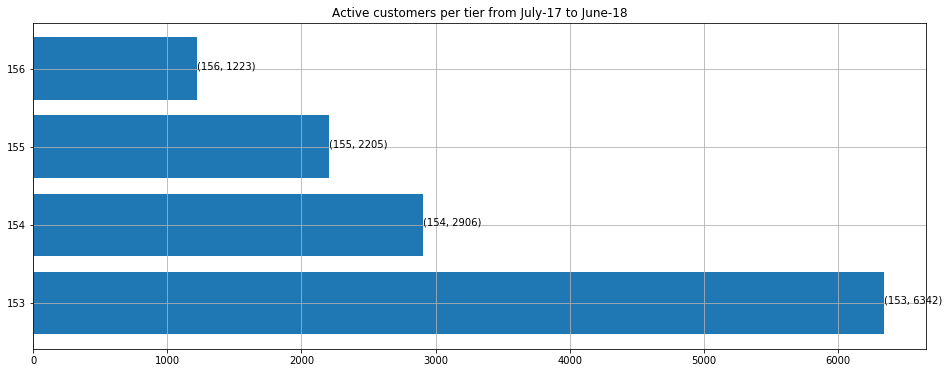

In [27]:
plt.figure(figsize=(16, 6))
plt.barh(cus_per_tier.index.values, cus_per_tier_new_values)
plt.yticks(cus_per_tier.index.values)
plt.title('Active customers per tier from July-17 to June-18')
ax = plt.gca()
for i, txt in enumerate(zip(cus_per_tier.index.values, cus_per_tier_new_values)):
    ax.annotate(txt, (cus_per_tier_new_values[i], cus_per_tier.index.values[i]))
plt.grid()

#### Number of average orders per year (mid 2017 - mid 2018)

In [28]:
data.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].nunique()

CZP_ZTQ_ID
153    32867
154    14899
155    10861
156     6283
Name: SCM_N_ORDER_NR, dtype: int64

In [29]:
tiers = [153, 154, 155, 156]

In [30]:
orders_per_week = data.groupby('WEEK_NUMBER')['SCM_N_ORDER_NR'].nunique()
#New mapping in order to have correlative week numbers
new_week_mapping = {}

In [31]:
for x, y in zip(list(orders_per_week[25:].index.values) + list(orders_per_week[:25].index.values), list(range(1,len(orders_per_week.index.values) + 1))):
    new_week_mapping[x] = y 

In [32]:
week_mapping = [new_week_mapping[i] for i in data['WEEK_NUMBER'].values]
#New column with the new week mapping
data['WEEK_NUMBER_ORDERED'] = week_mapping

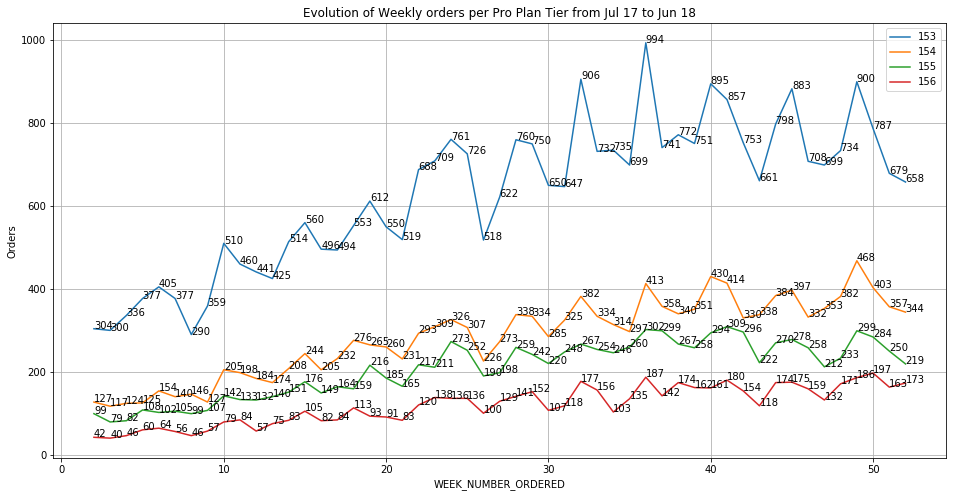

In [33]:
plt.figure(figsize=(16, 8))
for i in tiers:
    tier_data = data[data['CZP_ZTQ_ID'] == i]
    weekly_data = tier_data.groupby('WEEK_NUMBER_ORDERED')['SCM_N_ORDER_NR'].nunique()[1:] #exclude 1st week (week 26 overlapping)
    weekly_data.plot()
    ax = plt.gca()
    for i, txt in enumerate(weekly_data):
        ax.annotate(txt, (weekly_data.index[i], weekly_data.values[i]))
plt.grid(True)
plt.ylabel('Orders')
plt.title('Evolution of Weekly orders per Pro Plan Tier from Jul 17 to Jun 18')
plt.legend(tiers) 
plt.show()

#### Average Basket Value

In [34]:
order_values_per_tier = data.groupby(['CZP_ZTQ_ID', 'SCM_N_ORDER_NR'], as_index=False)['BASKET_VALUE'].mean()

In [35]:
order_values_per_tier.sample(5)

,CZP_ZTQ_ID,SCM_N_ORDER_NR,BASKET_VALUE
52420,155,102743911,77.16
17127,153,104268379,-3.99
43367,154,108425852,98.29
19227,153,105588041,55.19
30383,153,112213158,125.98


In [36]:
order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].describe()

,count,mean,std,min,25%,50%,75%,max
CZP_ZTQ_ID,,,,,,,,
153,32867.0,78.626556,47.141050,-12.00,47.49,66.44,95.62495,1030.72
154,14899.0,89.379485,55.117525,-18.48,51.27,78.35,108.26000,781.92
155,10861.0,83.510546,52.124059,-19.56,47.40,71.24,99.97000,806.85
156,6283.0,100.505093,67.532396,-19.48,54.85,88.34,122.70000,730.87


Due to high spreadness of the sample is more robust use the median

#### Average Sales

In [37]:
#12 months sales
order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].sum().round(2)

CZP_ZTQ_ID
153    2584219.01
154    1331664.95
155     907008.04
156     631473.50
Name: BASKET_VALUE, dtype: float64

In [38]:
# Monthly average sales
np.round(order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].sum() / 12, 2)

CZP_ZTQ_ID
153    215351.58
154    110972.08
155     75584.00
156     52622.79
Name: BASKET_VALUE, dtype: float64

In [39]:
# Weekly average sales
np.round(order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].sum() / 52, 2)

CZP_ZTQ_ID
153    49696.52
154    25608.94
155    17442.46
156    12143.72
Name: BASKET_VALUE, dtype: float64

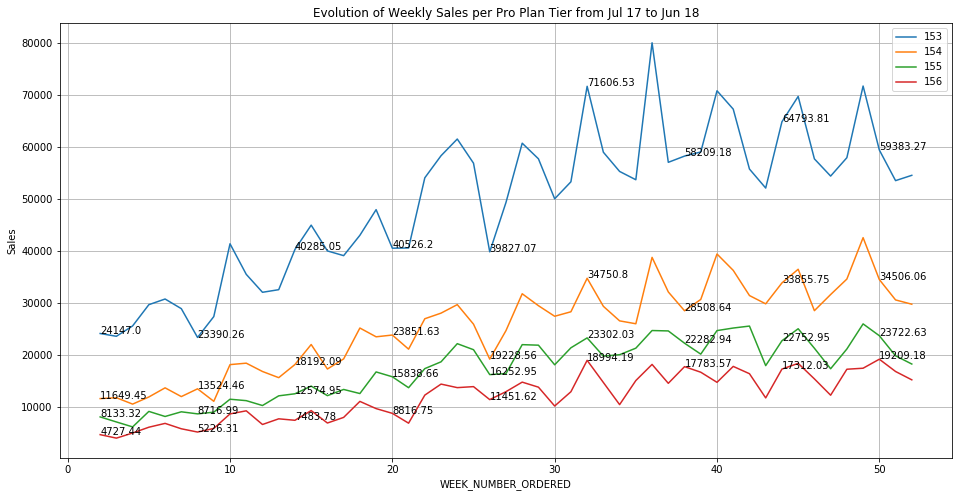

In [40]:
plt.figure(figsize=(16, 8))
for i in tiers:
    tier_data = data[data['CZP_ZTQ_ID'] == i]
    week_sales_tier = tier_data.groupby(['WEEK_NUMBER_ORDERED', 'SCM_N_ORDER_NR'], as_index=False)['BASKET_VALUE'].mean()
    weekly_data = week_sales_tier.groupby('WEEK_NUMBER_ORDERED')['BASKET_VALUE'].sum()[1:] #exclude 1st week (week 26 overlapping)
    weekly_data.plot()
    ax = plt.gca()
    for i, txt in enumerate(weekly_data):
        if i % 6 == 0:
            ax.annotate(np.round(txt, 2), (weekly_data.index[i], weekly_data.values[i]))
plt.grid(True)
plt.ylabel('Sales')
plt.title('Evolution of Weekly Sales per Pro Plan Tier from Jul 17 to Jun 18')
plt.legend(tiers) 
plt.show()

#### CM1 

In [41]:
data['ORDER_CM1'] = (data['SCM_D_FINANCE_CM1'] * data['POS_VALID']).groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [42]:
data['ORDER_NET_SALES'] = (data['SCM_D_ORIG_FINANCE_ORDER_NET'] * data['POS_VALID']).groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [43]:
data['ORDER_CM1%'] = data['ORDER_CM1'] / data['ORDER_NET_SALES'] * 100

In [44]:
data['ORDER_CM2'] = (data['SCM_D_FINANCE_CM2'] * data['POS_VALID']).groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [45]:
data['ORDER_CM2%'] = data['ORDER_CM2'] / data['ORDER_NET_SALES'] * 100

In [46]:
cm_values_per_tier = data.groupby(['CZP_ZTQ_ID', 'SCM_N_ORDER_NR'], as_index=False)[['ORDER_NET_SALES', 'ORDER_CM1', 
                                                                                     'ORDER_CM1%', 'ORDER_CM2',
                                                                                     'ORDER_CM2%']].mean()

In [47]:
cm_values_per_tier.sample(5).round(2)

,CZP_ZTQ_ID,SCM_N_ORDER_NR,ORDER_NET_SALES,ORDER_CM1,ORDER_CM1%,ORDER_CM2,ORDER_CM2%
20051,153,106035670,57.77,19.75,34.18,10.61,18.37
31401,153,112919321,75.99,13.85,18.23,6.13,8.07
60238,156,99396884,85.72,19.34,22.56,9.68,11.29
2002,153,92266042,81.52,13.95,17.12,3.55,4.35
36268,154,97998052,39.14,18.99,48.52,2.61,6.67


In [48]:
# CM1 per tier
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM1'].sum().round(2)

CZP_ZTQ_ID
153    548856.90
154    277183.65
155    185142.81
156    119991.64
Name: ORDER_CM1, dtype: float64

In [49]:
# CM1 per order in each tier
(cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM1'].sum() /\
cm_values_per_tier.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].count()).round(2)

CZP_ZTQ_ID
153    16.70
154    18.60
155    17.05
156    19.10
dtype: float64

In [50]:
# CM1% per tier
(cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM1'].sum() /\
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_NET_SALES'].sum() * 100).round(2)

CZP_ZTQ_ID
153    25.48
154    24.96
155    24.47
156    22.78
dtype: float64

In [51]:
# CM1% per order in each tier
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM1%'].mean().round(2)

CZP_ZTQ_ID
153    27.43
154    26.59
155    26.14
156    24.78
Name: ORDER_CM1%, dtype: float64

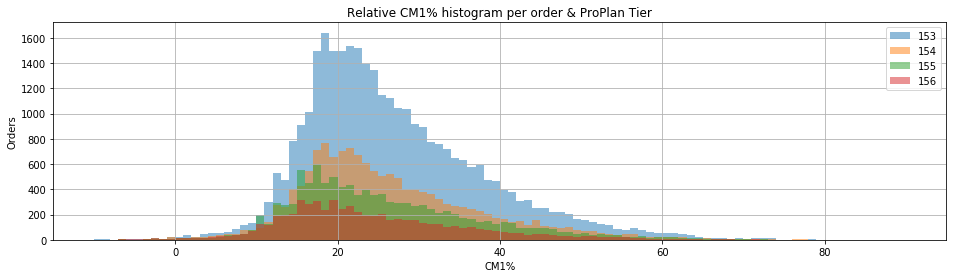

,Tier 153,Tier 154,Tier 155,Tier 156
count,32863.00,14896.00,10860.00,6283.00
mean,27.43,26.59,26.14,24.78
std,32.15,20.89,13.36,15.08
min,-1386.71,-1863.38,-105.26,-112.30
25%,19.09,18.61,17.22,16.22
50%,24.70,24.01,23.36,21.93
75%,33.15,32.40,32.38,30.90
max,5108.58,274.37,189.21,425.56


In [52]:
concat_df = pd.DataFrame()

plt.figure(figsize=(16,4))
plt.title('Relative CM1% histogram per order & ProPlan Tier')
plt.xlabel('CM1%')
plt.ylabel('Orders')

for i in tiers:
    tier_data = cm_values_per_tier[cm_values_per_tier['CZP_ZTQ_ID'] == i]
    tier_data['ORDER_CM1%'].hist(bins=100, range=(-10, 90), alpha=0.5)
    plt.legend([153, 154, 155, 156])
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(tier_data['ORDER_CM1%'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 153', 'Tier 154', 'Tier 155', 'Tier 156']
display(concat_df)

#### CM2

In [53]:
# CM2 per tier
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM2'].sum().round(2)

CZP_ZTQ_ID
153    195516.73
154    102147.47
155     60589.09
156     38411.62
Name: ORDER_CM2, dtype: float64

In [54]:
# CM2 per order in each tier
(cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM2'].sum() /\
cm_values_per_tier.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].count()).round(2)

CZP_ZTQ_ID
153    5.95
154    6.86
155    5.58
156    6.11
dtype: float64

In [55]:
# CM2% per tier
(cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM2'].sum() /\
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_NET_SALES'].sum() * 100).round(2)

CZP_ZTQ_ID
153    9.08
154    9.20
155    8.01
156    7.29
dtype: float64

In [56]:
# CM2% per order in each tier
cm_values_per_tier.groupby('CZP_ZTQ_ID')['ORDER_CM2%'].mean().round(2)

CZP_ZTQ_ID
153    8.97
154    8.93
155    7.70
156    7.56
Name: ORDER_CM2%, dtype: float64

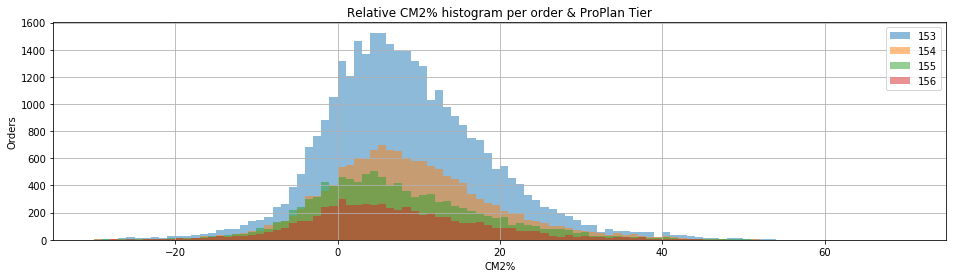

,Tier 153,Tier 154,Tier 155,Tier 156
count,32863.00,14896.00,10860.00,6283.00
mean,8.97,8.93,7.70,7.56
std,50.53,23.42,14.19,22.89
min,-1934.30,-2211.99,-236.28,-301.51
25%,1.80,1.97,0.00,-0.10
50%,7.47,7.74,5.80,5.84
75%,14.39,14.55,13.69,13.34
max,8497.43,309.19,225.75,1079.96


In [57]:
concat_df = pd.DataFrame()

plt.figure(figsize=(16,4))
plt.title('Relative CM2% histogram per order & ProPlan Tier')
plt.xlabel('CM2%')
plt.ylabel('Orders')

for i in tiers:
    tier_data = cm_values_per_tier[cm_values_per_tier['CZP_ZTQ_ID'] == i]
    tier_data['ORDER_CM2%'].hist(bins=100, range=(-30, 70), alpha=0.5)
    plt.legend([153, 154, 155, 156])
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(tier_data['ORDER_CM2%'].describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 153', 'Tier 154', 'Tier 155', 'Tier 156']
display(concat_df)

#### Share of Proplan Sales per Tier

Let's get the physical articles belonging to PG4 groups: 283, 286, 192127.

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
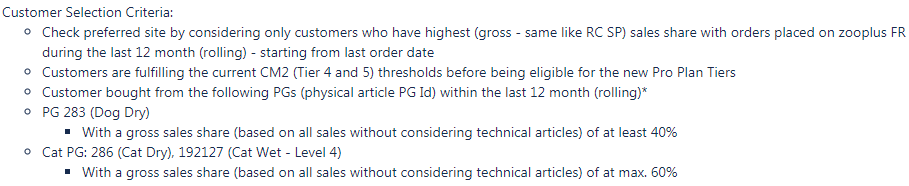

In [58]:
query = """select *
from zoocube.DDSTD_PPR_PHYS_PRODUCT
where PPR_N_LEVEL4_ID in (283, 286, 192127)"""

In [59]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
curs = conn.cursor()
pg4ids = pd.read_sql(query, con = conn)
conn.close()

In [60]:
pg4ids

,PPR_N_KEY_PHYS_PRODUCT,PPR_N_PHY_PRODUCT_ID,PPR_N_PHY_ARTICLE_ID,PPR_V_PRODUCT_DESC,PPR_V_LOGISTICS_DESC,PPR_N_LEVEL1_ID,PPR_V_LEVEL1_DESC,PPR_N_LEVEL2_ID,PPR_V_LEVEL2_DESC,PPR_N_LEVEL3_ID,...,PPR_IS_HIGH_CLV,PPR_BRAND,PPR_PG_PRIORITY,PPR_EAN,PPR_NR_AT_SUPPLIER,PPR_AP_IS_LISTED,PPR_ARTICLE_CLASS_ID,PPR_ART_CLASS_DESC,PPR_TAX_CODE,PPR_APA_DESC
0,5771,2159,3296,2159 - Pro Plan Dog Adult Dog Huhn + Reis,3296 - Pro Plan Dog Adult Dog - 15 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000583,5100138,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
1,5772,2159,3295,2159 - Pro Plan Dog Adult Dog Huhn + Reis,3295 - Pro Plan Dog Adult Dog H- 3 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,7613033208263,12150307,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
2,5773,2160,1495,2160 - Pro Plan Dog Performance Huhn,1495 - Pro Plan Dog Performanc- 800 g,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000-651,1023300,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
3,5775,2160,3418,2160 - Pro Plan Dog Performance Huhn,3418 - Pro Plan Dog Performanc- 15 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000682,05100158,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
4,5776,2160,3416,2160 - Pro Plan Dog Performance Huhn,3416 - Pro Plan Dog Performance- 3 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,8410650530306,8473000,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
5,5777,2161,1500,2161 - Pro Plan Dog Adult Light Huhn,1500 - Pro Plan Dog Adult Ligh- 800 g,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000-705,8143000,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
6,5778,2161,11891,2161 - Pro Plan Dog Adult Light Huhn,11891 - Pro Plan Dog Adult Light- 3 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,07613033209994,12150387,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
7,5779,2161,3420,2161 - Pro Plan Dog Adult Light Huhn,3420 - Pro Plan Dog Adult Ligh- 15 kg,2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000736,5100163,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
8,5780,2161,3419,2161 - Pro Plan Dog Adult Light Huhn,"3419 - Pro Plan Dog Adult Lig- 7,5 kg",2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,8410650530758,8454000,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU
9,5782,2158,3294,2158 - Pro Plan Dog Puppy Huhn + Reis,"3294 - Pro Plan Dog Puppy Huh- 7,5 kg",2719,2719 - zooplus.de,2,2 - Hund,251,...,High CLV Article,Pro Plan,2,3596980000439,5119955,0,26,"Premium Brands by P, Nestle and Hills",Low,SKU


In [61]:
proplan_arts = list(set(pg4ids['PPR_N_PHY_ARTICLE_ID']))

In [62]:
proplan_names = list(data[data['SCM_AP_ID'].isin(proplan_arts)]['PP_NAME'].unique())

In [63]:
len(proplan_names)

55

In [64]:
proplan_names

['Pro Plan Cat Sterilised reich an Truthahn',
 'Pro Plan Cat Adult Delicate',
 'Pro Plan Cat Housecat',
 'Pro Plan Derma Plus',
 'Pro Plan Cat Sterilised reich an Lachs',
 'Pro Plan Cat Adult Cat Huhn & Reis',
 'Pro Plan Dental Plus',
 'Pro Plan Kitten/Junior  Huhn & Reis',
 'Pro Plan Cat Adult Light',
 'Pro Plan Large Robust Adult Lamm',
 'Pro Plan Large Ath. Adult Lamm',
 'Pro Plan Large Adult Atheltic Huhn & Reis',
 'Pro Plan Medium Adult Huhn & Reis',
 'Pro Plan All sizes Adult Light Sterilised Huhn & Reis',
 'Pro Plan Small & Mini Adult Sensitive Skin Lachs & Reis',
 'Pro Plan Large Adult Robust Huhn & Reis',
 'Pro Plan Medium Adult Sensitive Skin Lachs & Reis',
 'Pro Plan Medium Adult Lamm',
 'Pro Plan Medium Adult Sensitive Digestion Huhn & Reis',
 'Pro Plan Medium & Large Adult 7+ Huhn & Reis',
 'Pro Plan Large Puppy Athletic Huhn & Reis',
 'Pro Plan Medium Puppy Huhn & Reis',
 'Pro Plan Medium & Large Adult 7+ Sensitive Skin Lachs & Reis',
 'PP Large Adult Athletic Sensitive S

In [65]:
#Let's create a flag for this order positions including ProPlan articles
data['IS_PRO_PLAN_ART'] = (data['SCM_AP_ID'].isin(proplan_arts)) * 1

In [66]:
data[['PP_NAME', 'POS_VALID', 'SCM_SALES_BMF', 'SCM_SALES_CANCEL_BMF', 'IS_PRO_PLAN_ART']].sample(20)

,PP_NAME,POS_VALID,SCM_SALES_BMF,SCM_SALES_CANCEL_BMF,IS_PRO_PLAN_ART
119053,Gourmet Diamant 85 g,1,12.99,0.0,0
103596,Animonda INTEGRA Protect Niere Dose 6 x 400 g,1,29.97,0.0,0
212158,Hunter Hundespielzeug Spike Ball mit Kordel,1,8.99,0.0,0
13893,Katzenspielzeug Jumping Stars,1,2.49,0.0,0
165446,Megapack Cosma Original 6 x 400g,1,11.99,0.0,0
8748,JR Farm Nager-Traum,1,0.00,0.0,0
10049,Hill´s PD Canine Metabolic & Mobility,1,134.99,0.0,0
93059,Savings Plan,1,5.99,0.0,0
99395,Savings Plan,1,2.99,0.0,0
124954,Royal Canin - Vet Diet - Renal - Megapack,1,20.99,0.0,0


In [67]:
# Get Pro Plan Articles order positions
proplan_o_pos = data[data['IS_PRO_PLAN_ART'] == 1]

In [68]:
pp_o_pos = proplan_o_pos.copy()

In [69]:
pp_o_pos['PP_SALES'] = pp_o_pos['SCM_SALES_BMF'] * pp_o_pos['POS_VALID']

In [70]:
# Quantify ProPlan Articles Sales per Tier Qualifier
proplan_sales_per_tier = pp_o_pos.groupby('CZP_ZTQ_ID')['PP_SALES'].sum().round(2)
proplan_sales_per_tier

CZP_ZTQ_ID
153    894980.90
154    470215.81
155    347717.33
156    258796.41
Name: PP_SALES, dtype: float64

In [71]:
# Obtain Sales Per Tier Qualifier
sales_per_tier = order_values_per_tier.groupby('CZP_ZTQ_ID')['BASKET_VALUE'].sum().round(2)
sales_per_tier

CZP_ZTQ_ID
153    2584219.01
154    1331664.95
155     907008.04
156     631473.50
Name: BASKET_VALUE, dtype: float64

**Share of ProPlan Sales per Tier:**

In [72]:
share_s_pp_tier = (proplan_sales_per_tier/sales_per_tier * 100).round(2) 
share_s_pp_tier

CZP_ZTQ_ID
153    34.63
154    35.31
155    38.34
156    40.98
dtype: float64

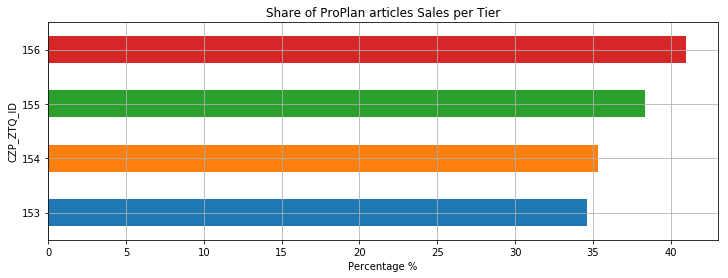

In [73]:
plt.figure(figsize=(12, 4))
share_s_pp_tier.plot(kind='barh')
plt.title('Share of ProPlan articles Sales per Tier')
plt.xlabel('Percentage %')
plt.grid()

#### Share of Orders with Proplan per Tier

In [74]:
# Orders having ProPlan articles per Tier
orders_with_proplan_per_tier = proplan_o_pos.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].nunique()
orders_with_proplan_per_tier

CZP_ZTQ_ID
153    14758
154     6700
155     5275
156     3152
Name: SCM_N_ORDER_NR, dtype: int64

In [75]:
# Total orders per Tier
orders_per_tier = data.groupby('CZP_ZTQ_ID')['SCM_N_ORDER_NR'].nunique()
orders_per_tier

CZP_ZTQ_ID
153    32867
154    14899
155    10861
156     6283
Name: SCM_N_ORDER_NR, dtype: int64

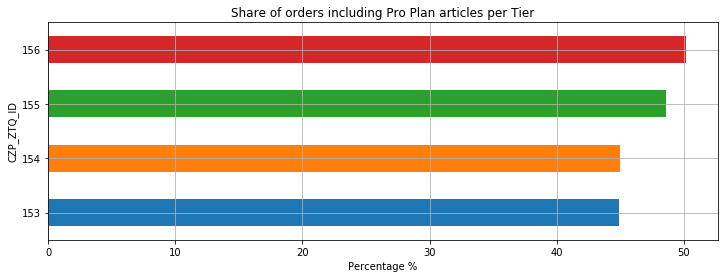

In [76]:
share_o_pp_tier = (orders_with_proplan_per_tier / orders_per_tier * 100).round(2)
plt.figure(figsize=(12, 4))
share_o_pp_tier.plot(kind='barh')
plt.title('Share of orders including Pro Plan articles per Tier')
plt.xlabel('Percentage %')
plt.grid()

In [77]:
# Share of orders with Pro Plan articles per Tier
share_o_pp_tier

CZP_ZTQ_ID
153    44.90
154    44.97
155    48.57
156    50.17
Name: SCM_N_ORDER_NR, dtype: float64

In [78]:
# Share of total orders having ProPlan articles
(orders_with_proplan_per_tier.sum() / orders_per_tier.sum()).round(2)

0.46

#### Repurchasing rate within specific time period per Tier

In [79]:
data['CUS_N_KEY_CUSTOMER'].nunique()

12676

In [80]:
#Run calculation at a customer level
customers = pd.DataFrame(columns=['CUSTOMER_ID', 'TIER', 'ORDERS', '1ST_O_DATE', '1ST_O_COUNT',
                                  '28D_DATE', 'N_28D', '56D_DATE', 'N_56D', '84D_DATE','N_84D', '180D_DATE','N_180D', 
                                  'SALES', 'NET_SALES', 'BASKET_AVG', 
                                  'CM1', 'CM1_AVG', 'CM1%', 'CM2', 'CM2_AVG', 'CM2%'
                                  ])

for n, cus in enumerate(data['CUS_N_KEY_CUSTOMER'].unique()):
    cus_data = data[data['CUS_N_KEY_CUSTOMER'] == cus]
    tier = cus_data['CZP_ZTQ_ID'].unique()
    orders = cus_data['SCM_N_ORDER_NR'].nunique()
    first_ord_in_ds = cus_data['OSP_KO_COUNT_NET'].min()
    first_order_date = cus_data[cus_data['OSP_KO_COUNT_NET'] == first_ord_in_ds]['TDT_T_KEY_ORDER_DATE'].dt.date.unique()[0]
    rep_date_28 = first_order_date + timedelta(days = 28)
    rep_date_56 = first_order_date + timedelta(days = 56)
    rep_date_84 = first_order_date + timedelta(days = 84)
    rep_date_180 = first_order_date + timedelta(days = 180)
    n_orders_28d = cus_data[cus_data['TDT_T_KEY_ORDER_DATE'].dt.date <= rep_date_28]['OSP_KO_COUNT_NET'].max()
    n_orders_56d = cus_data[cus_data['TDT_T_KEY_ORDER_DATE'].dt.date <= rep_date_56]['OSP_KO_COUNT_NET'].max()
    n_orders_84d = cus_data[cus_data['TDT_T_KEY_ORDER_DATE'].dt.date <= rep_date_84]['OSP_KO_COUNT_NET'].max()
    n_orders_180d = cus_data[cus_data['TDT_T_KEY_ORDER_DATE'].dt.date <= rep_date_180]['OSP_KO_COUNT_NET'].max()
        
    sales = (cus_data['SCM_SALES_BMF'] * cus_data['POS_VALID']).sum()
    net_sales = (cus_data['SCM_D_ORIG_FINANCE_ORDER_NET'] * cus_data['POS_VALID']).sum()
    basket_avg = sales / orders
    cm1 = (cus_data['SCM_D_FINANCE_CM1'] * cus_data['POS_VALID']).sum()
    cm1_avg = cm1 / orders
    cm1_perc = cm1 / net_sales * 100
    cm2 = (cus_data['SCM_D_FINANCE_CM2'] * cus_data['POS_VALID']).sum()
    cm2_avg = cm2 / orders
    cm2_perc = cm2 / net_sales * 100
    
    row_ = [cus, tier, orders, first_order_date, first_ord_in_ds, rep_date_28, n_orders_28d, rep_date_56,
            n_orders_56d, rep_date_84, n_orders_84d, rep_date_180, n_orders_180d,
            sales, net_sales, basket_avg, cm1, cm1_avg, cm1_perc, cm2, cm2_avg, cm2_perc]
    row_ = pd.DataFrame([row_], columns=customers.columns)
    customers = pd.concat([customers, row_], ignore_index=True)
    
    if n % 1000 == 0:
        print(n)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [81]:
customers.head(5).round(2)

,CUSTOMER_ID,TIER,ORDERS,1ST_O_DATE,1ST_O_COUNT,28D_DATE,N_28D,56D_DATE,N_56D,84D_DATE,...,N_180D,SALES,NET_SALES,BASKET_AVG,CM1,CM1_AVG,CM1%,CM2,CM2_AVG,CM2%
0,6560483,[156],5,2017-11-20,5,2017-12-18,5,2018-01-15,6,2018-02-12,...,9,527.64,439.70,105.53,136.85,27.37,31.12,64.00,12.80,14.56
1,8755557,[156],10,2017-12-17,43,2018-01-14,45,2018-02-11,46,2018-03-11,...,52,1622.94,1352.45,162.29,254.22,25.42,18.80,66.69,6.67,4.93
2,15963235,[156],4,2017-12-02,3,2017-12-30,3,2018-01-27,3,2018-02-24,...,6,403.05,335.88,100.76,122.62,30.65,36.51,70.90,17.72,21.11
3,10157201,[156],6,2018-01-05,36,2018-02-02,37,2018-03-02,38,2018-03-30,...,41,1561.77,1301.47,260.30,421.74,70.29,32.41,250.55,41.76,19.25
4,8508366,[156],4,2018-01-01,35,2018-01-29,35,2018-02-26,36,2018-03-26,...,38,490.78,408.98,122.69,76.15,19.04,18.62,26.80,6.70,6.55


In [82]:
customers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12676 entries, 0 to 12675
Data columns (total 22 columns):
CUSTOMER_ID    12676 non-null object
TIER           12676 non-null object
ORDERS         12676 non-null object
1ST_O_DATE     12676 non-null object
1ST_O_COUNT    12676 non-null object
28D_DATE       12676 non-null object
N_28D          12676 non-null object
56D_DATE       12676 non-null object
N_56D          12676 non-null object
84D_DATE       12676 non-null object
N_84D          12676 non-null object
180D_DATE      12676 non-null object
N_180D         12676 non-null object
SALES          12676 non-null float64
NET_SALES      12676 non-null float64
BASKET_AVG     12676 non-null float64
CM1            12676 non-null float64
CM1_AVG        12676 non-null float64
CM1%           12676 non-null float64
CM2            12676 non-null float64
CM2_AVG        12676 non-null float64
CM2%           12676 non-null float64
dtypes: float64(9), object(13)
memory usage: 2.1+ MB


In [83]:
customers[['ORDERS', '1ST_O_COUNT', 'N_28D', 'N_56D', 'N_84D', 'N_180D']] = customers[['ORDERS', '1ST_O_COUNT', 'N_28D', 'N_56D', 'N_84D', 'N_180D']].astype(int)

In [84]:
customers['1ST_O_DATE'] = pd.to_datetime(customers['1ST_O_DATE'], format='%Y-%m-%d')

In [85]:
customers['TIER'] = customers['TIER'].astype(str)

In [86]:
# 1 if order counter increase from one period to the previous one
customers['R_IN_28D'] = (customers['N_28D'] > customers['1ST_O_COUNT']) * 1
customers['R_IN_56D'] = (customers['N_56D'] > customers['N_28D']) * 1
customers['R_IN_84D'] = (customers['N_84D'] > customers['N_56D']) * 1
customers['R_IN_180D'] = (customers['N_180D'] > customers['N_84D']) * 1

In [87]:
customers['RR_28D'] = customers['R_IN_28D']
customers['RR_56D'] = (customers['R_IN_28D'] | customers['R_IN_56D']) * 1
customers['RR_84D'] = (customers['RR_56D'] | customers['R_IN_84D']) * 1
customers['RR_180D'] = (customers['RR_84D'] | customers['R_IN_180D']) * 1

As we have a non-rolling time window, we need to know which customer is include/exclude for each time period repurchase rate...

In [88]:
customers['SUIT_180D'] = ((data['TDT_T_KEY_ORDER_DATE'].max().date() - timedelta(days=180)) >= customers['1ST_O_DATE']) * 1

In [89]:
customers['SUIT_84D'] = ((data['TDT_T_KEY_ORDER_DATE'].max().date() - timedelta(days=84)) >= customers['1ST_O_DATE']) * 1

In [90]:
customers['SUIT_56D'] = ((data['TDT_T_KEY_ORDER_DATE'].max().date() - timedelta(days=56)) >= customers['1ST_O_DATE']) * 1

In [91]:
customers['SUIT_28D'] = ((data['TDT_T_KEY_ORDER_DATE'].max().date() - timedelta(days=28)) >= customers['1ST_O_DATE']) * 1

Let's exclude customers transitioning between tiers in our time window - 133 in total -

In [92]:
customers['TIER'].value_counts().index.values[:4]

array(['[153]', '[154]', '[155]', '[156]'], dtype=object)

In [93]:
selected_tiers = [
    '[153]', '[154]', '[155]', '[156]'
]
selected_tiers

['[153]', '[154]', '[155]', '[156]']

In [94]:
sp_customers = customers[customers['TIER'].isin(selected_tiers)]

In [95]:
# 133 located and excluded
customers['CUSTOMER_ID'].nunique(), sp_customers['CUSTOMER_ID'].nunique()

(12676, 12543)

In [96]:
def get_number_from_string(i):
    changes = i.replace('[', '').replace(']', '')
    return int(changes)

In [97]:
t_customers = sp_customers.copy()

In [98]:
t_customers['TIER'] = t_customers['TIER'].map(get_number_from_string)

Now we calculate (flag 1, 0) if the suitable customers for each period have repurchased or not

In [99]:
t_customers['R_28D'] = t_customers['SUIT_28D'] * t_customers['RR_28D']
t_customers['R_56D'] = t_customers['SUIT_56D'] * t_customers['RR_56D']
t_customers['R_84D'] = t_customers['SUIT_84D'] * t_customers['RR_84D']
t_customers['R_180D'] = t_customers['SUIT_180D'] * t_customers['RR_180D']

In [100]:
t_customers.columns

Index(['CUSTOMER_ID', 'TIER', 'ORDERS', '1ST_O_DATE', '1ST_O_COUNT',
       '28D_DATE', 'N_28D', '56D_DATE', 'N_56D', '84D_DATE', 'N_84D',
       '180D_DATE', 'N_180D', 'SALES', 'NET_SALES', 'BASKET_AVG', 'CM1',
       'CM1_AVG', 'CM1%', 'CM2', 'CM2_AVG', 'CM2%', 'R_IN_28D', 'R_IN_56D',
       'R_IN_84D', 'R_IN_180D', 'RR_28D', 'RR_56D', 'RR_84D', 'RR_180D',
       'SUIT_180D', 'SUIT_84D', 'SUIT_56D', 'SUIT_28D', 'R_28D', 'R_56D',
       'R_84D', 'R_180D'],
      dtype='object')

**Repurchasing Rate in 28 days per Tier:** 

In [101]:
tier_rr_28d = (t_customers.groupby('TIER')['R_28D'].sum() / t_customers.groupby('TIER')['SUIT_28D'].sum() * 100).round(2)
tier_rr_28d

TIER
153    22.51
154    21.95
155    21.04
156    20.61
dtype: float64

**Repurchasing Rate in 56 days per Tier:** 

In [102]:
tier_rr_56d = (t_customers.groupby('TIER')['R_56D'].sum() / t_customers.groupby('TIER')['SUIT_56D'].sum() * 100).round(2)
tier_rr_56d

TIER
153    52.75
154    50.38
155    51.36
156    52.63
dtype: float64

**Repurchasing Rate in 84 days per Tier:** 

In [103]:
tier_rr_84d = (t_customers.groupby('TIER')['R_84D'].sum() / t_customers.groupby('TIER')['SUIT_84D'].sum() * 100).round(2)
tier_rr_84d

TIER
153    72.81
154    71.00
155    72.05
156    72.86
dtype: float64

**Repurchasing Rate in 180 days per Tier:** 

In [104]:
tier_rr_180d = (t_customers.groupby('TIER')['R_180D'].sum() / t_customers.groupby('TIER')['SUIT_180D'].sum() * 100).round(2)
tier_rr_180d

TIER
153    91.07
154    92.56
155    92.68
156    95.10
dtype: float64

In the nearest short-term (28d) low discount tiers (153, 154) have a high repurchasing rate, also their median basket values are 
lower, so that could be explain by this. 56 and 84 days periods, especially the 2nd one stay with very similar repurchasing rates among tiers.
For the mid-term (6 months), the higher the tier the greater the repurchase rate.

#### Customer behaviour

In [105]:
data.groupby('CUS_N_KEY_CUSTOMER')['SCM_N_ORDER_NR'].nunique().describe()

count    12676.000000
mean         5.120701
std          4.653563
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         91.000000
Name: SCM_N_ORDER_NR, dtype: float64

In [106]:
# We create a dictionary having Customer ID as key and Lead PG4 from each order 
#as the values in a list  -sorted from order 1 to n-
cus_dict_pg4 = {}

for i in data['CUS_N_KEY_CUSTOMER'].unique():
    cus_data = data[data['CUS_N_KEY_CUSTOMER'] == i].groupby('OSP_KO_COUNT_NET', as_index=False)['OSP_4_LEAD_P_PG_ID'].mean()
    cus_dict_pg4[i] = list(cus_data.sort_values(by='OSP_KO_COUNT_NET')['OSP_4_LEAD_P_PG_ID'])

In [107]:
# We create another customer based dictionary having Customer ID as key and Sales from each order 
# as the values in a list  -sorted from order 1 to n-
cus_dict_sales = {}

for i in data['CUS_N_KEY_CUSTOMER'].unique():
    cus_data = data[data['CUS_N_KEY_CUSTOMER'] == i].groupby('OSP_KO_COUNT_NET', as_index=False)['BASKET_VALUE'].mean()
    cus_dict_sales[i] = list(cus_data.sort_values(by='OSP_KO_COUNT_NET')['BASKET_VALUE'].round(2))

In [108]:
chosen_pg4 = [283, 286, 192127]

In [109]:
# Between 0 and 1 we create a scale of how far are customer orders Lead PG4 compared with the chosen ones. 
# 0 means chosen PG4 iDs appearing in every order and 1 no chosen PG4.

cus_dict_info = {}

for i in np.sort(data['CUS_N_KEY_CUSTOMER'].unique()):
    cus_dict_info[i] = {}
    #cus_dict_info[i]['pg4'] = cus_dict_pg4[i]
    #cus_dict_info[i]['basket_values'] = cus_dict_sales[i]
    cus_dict_info[i]['total_sales'] = sum(cus_dict_sales[i]) # sum values in the customer sales list from the dictionary
    cus_dict_info[i]['orders'] = len(cus_dict_sales[i]) # get the length of the list, one position per order
    cus_dict_info[i]['orders_info'] = [(x, y) for x, y in zip(cus_dict_pg4[i], cus_dict_sales[i])] # sorted tuple (lead PG4, sales) 
    cus_dict_info[i]['distance'] = (len(cus_dict_sales[i]) - sum([pg4 in chosen_pg4 for pg4 in cus_dict_pg4[i]])) / len(cus_dict_pg4[i])
    c = Counter(cus_dict_pg4[i])
    ord_per_pg4 = sorted(c.most_common() , key= lambda x: x[0], reverse=True)
    sales_per_pg4 = sorted([(pg4_,sum([sales_ for pg_, sales_ in cus_dict_info[i]['orders_info'] if pg_== pg4_])) 
                                         for pg4_ in set([pg4 for pg4, sales in cus_dict_info[i]['orders_info']])], key= lambda x: x[0], reverse=True)
    cus_dict_info[i]['pg4_ord_sales'] = sorted([(x[0], x[1], y[1]) for x, y in zip(ord_per_pg4, sales_per_pg4)], key= lambda x: (x[1], x[2]), reverse=True)
    cus_dict_info[i]['main_pg4'] = cus_dict_info[i]['pg4_ord_sales'][0][0]
    cus_dict_info[i]['main_pg4_%_ord'] = np.round(cus_dict_info[i]['pg4_ord_sales'][0][1] / cus_dict_info[i]['orders'], 2)
    cus_dict_info[i]['main_pg4_%_sales'] = np.round(cus_dict_info[i]['pg4_ord_sales'][0][2] / cus_dict_info[i]['total_sales'], 2)

In [110]:
cus_attr = pd.DataFrame.from_dict(cus_dict_info, orient='index').round(2)

In [111]:
cus_attr.head(10)
# orders_info: each tuple has (Lead PG4, basket value) and are sorted from 1st order to n
# pg4_ord_sales: info per tuple (lead PG4, orders in which the PG4 is Lead PG, sales from those orders)
# - orders & sales aggregated by Lead PG4 and sorted 1st by orders 'descending' and 2nd by sales 'descending' -
# main_pg4: Lead PG4 from the pg4_ord_sales 1st tuple: the one having more orders or more sales value (in case of orders equality)
# main_pg4_%_ord: orders from the pg4_ord_sales 1st tuple / total orders
# main_pg4_%_sales: sales from the pg4_ord_sales 1st tuple / total sales

,total_sales,orders,orders_info,distance,pg4_ord_sales,main_pg4,main_pg4_%_ord,main_pg4_%_sales
372507,129.38,2,"[(283, 87.28), (1412, 42.1)]",0.50,"[(283, 1, 87.28), (1412, 1, 42.1)]",283.0,0.50,0.67
603899,169.74,1,"[(2072, 169.74)]",1.00,"[(2072, 1, 169.74)]",2072.0,1.00,1.00
613442,540.25,9,"[(151599, 75.07), (151599, 68.45), (31962, 72....",1.00,"[(9498, 4, 198.18), (151599, 3, 196.6799999999...",9498.0,0.44,0.37
626438,1199.95,12,"[(286, 97.72), (719, 93.25), (81397, 64.64), (...",0.58,"[(286, 5, 523.2), (719, 5, 514.2900000000001),...",286.0,0.42,0.44
635902,1062.26,18,"[(304, 42.7), (39209, 52.39), (81397, 60.76), ...",1.00,"[(72002, 8, 504.28), (81397, 2, 109.15), (304,...",72002.0,0.44,0.47
643290,428.17,10,"[(682, 35.87), (31963, 61.37), (528, 28.79), (...",1.00,"[(31963, 4, 180.41000000000003), (528, 3, 129....",31963.0,0.40,0.42
648828,91.18,1,"[(283, 91.18)]",0.00,"[(283, 1, 91.18)]",283.0,1.00,1.00
682209,1074.96,8,"[(40419.882352941175, 133.95), (286.0, 214.1),...",0.75,"[(683.0, 3, 485.37), (286.0, 2, 311.85), (4041...",683.0,0.38,0.45
684441,262.61,3,"[(683, 112.61), (207640, 93.97), (128, 56.03)]",1.00,"[(683, 1, 112.61), (207640, 1, 93.97), (128, 1...",683.0,0.33,0.43
684669,216.53,1,"[(10331, 216.53)]",1.00,"[(10331, 1, 216.53)]",10331.0,1.00,1.00


In [112]:
cus_attr['main_pg4_ord'] = [i[0][1] for i in cus_attr['pg4_ord_sales']]

In [113]:
cus_attr['main_pg4_sales'] = [i[0][2] for i in cus_attr['pg4_ord_sales']]

In [114]:
# 8906 customers having at least 3 orders
cus_attr_3ord = cus_attr[cus_attr['orders'] >= 3]

In [115]:
len(cus_attr_3ord)

8906

In [116]:
cus_attr_3ord['distance'].describe()

count    8906.000000
mean        0.569810
std         0.412044
min         0.000000
25%         0.140000
50%         0.670000
75%         1.000000
max         1.000000
Name: distance, dtype: float64

Text(0.5,0,'Distance')

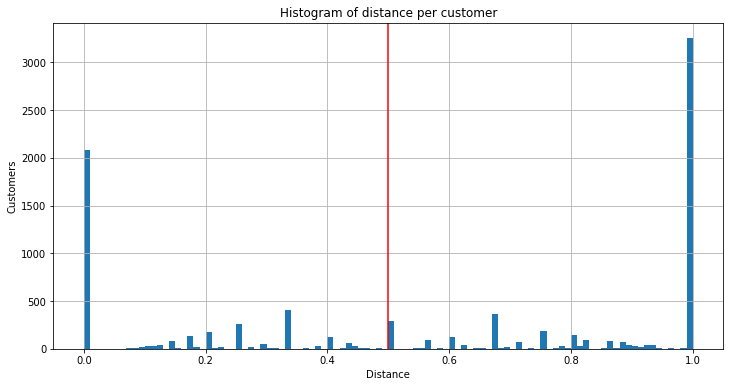

In [117]:
plt.figure(figsize=(12, 6))
cus_attr_3ord['distance'].hist(bins=100)
plt.axvline(x=0.5, color='red')
plt.title('Histogram of distance per customer')
plt.ylabel('Customers')
plt.xlabel('Distance')

In [118]:
# 4917 (55%) customers from 8906 (>= 3 orders) placed more than the half of their orders in the selected period 
# without any chosen PG4 IDs as Lead PG
cus_attr_3ord[cus_attr_3ord['distance'] > 0.50].index

Int64Index([  613442,   626438,   635902,   643290,   682209,   684441,
              684726,   684970,   707557,   711674,
            ...
            19157984, 19220389, 19228937, 19247375, 19256376, 19331720,
            19417647, 19421567, 19621504, 19898145],
           dtype='int64', length=4917)

In [119]:
cus_attr_3ord['main_pg4'].value_counts().head(25)

283.0       3534
286.0        636
683.0        428
682.0        281
81397.0      170
31962.0      155
95904.0      141
180361.0     141
2127.0       141
81396.0      139
31963.0      136
719.0        130
10331.0      128
17798.0      114
192127.0     106
720.0        104
255.0         99
17963.0       99
81431.0       77
2071.0        74
2072.0        71
35825.0       68
9425.0        63
261925.0      62
47690.0       60
Name: main_pg4, dtype: int64

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
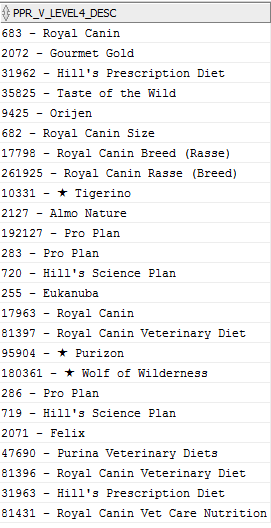

- Pro Plan Prods are Lead PGs for 4276 customers
- Royal Canin Prods are Lead PGs for 1370 customers
- Hill's Prods are Lead PGs for 525 customers
- Private label Prods are Lead PGs for 410 customers

#### Basket analysis (apriori algorithm)

In [120]:
data['PP_NAME'] = data['PP_NAME'].astype(str)

In [121]:
basket_info = list(data.groupby('SCM_N_ORDER_NR')['PP_NAME'].apply(list).values)

In [122]:
len(basket_info)

64910

In [123]:
basket_info[:5]

[['Pro Plan Cat Sterilised reich an Lachs',
  'Pro Plan Cat Sterilised reich an Lachs',
  'Moser Dematter',
  'INNE CAT KITTEN',
  'Megapack Catessy Pouch 12x100g',
  'Sanabelle Adult mit Geflügel',
  'Lukullus Nassfutter',
  'Royal Canin Exigent 42',
  'Gimpet Pudding für Katzen 150g',
  'MP Smilla Geflügeltöpfchen 6 x 800 g ',
  'Pedigree Riesenknochen',
  'Hunter Halsband Ecco Sport Vario Basic, rot',
  'Rocco Sensible Nassfutter',
  'nan',
  'nan',
  'nan'],
 ['Royal Canin Vet Care Senior Consult Stage 1 Balance',
  'Savings Plan',
  'Whiskas Knusper-Taschen',
  'Whiskas Knusper-Taschen',
  'Whiskas Knusper-Taschen',
  'Whiskas Knusper-Taschen',
  'Whiskas Crunch 100 g',
  'Seresto Collier Katze (FR)',
  'Catsan Hygienestreu ',
  'Megapack Gourmet Perle 24 x 85 g',
  'nan'],
 ['RAZAS  Schinkenknochen',
  'Alpha Spirit halber Schinkenknochen',
  'Megapack Hills Frischebeutel 12 x 85 g',
  'Barkoo Kauknochen geknotet',
  'Lukullus Kauknochen mit Huhn',
  'Chenillematte',
  'Royal Can

In [124]:
basket_info = [[item for item in basket if item != 'nan'] for basket in basket_info]

In [125]:
basket_info[:5][0][0]

'Pro Plan Cat Sterilised reich an Lachs'

In [126]:
len(basket_info)

64910

In [127]:
import apriori_py3

In [128]:
L,suppData = apriori_py3.apriori(basket_info, minSupport = 0.005)

In [129]:
L

[[frozenset({'Purizon Cat Sterilised Huhn & Fisch'}),
  frozenset({'RC MP wet cat food entry pack 4x85g pouches'}),
  frozenset({'Cosma gefriergetrocknete Snacks große Tube'}),
  frozenset({'Catessy Knabber-Snack 65 g'}),
  frozenset({'Royal Canin Sensible 33'}),
  frozenset({'Royal Canin Veterinary Diet Cat- Urinary S/O'}),
  frozenset({'Tigerino Canada Unscented "Sensitive"'}),
  frozenset({'Whiskas 1+ Megapack 12 x 100 g '}),
  frozenset({'Megapack cosma nature 6 x 70 g Dose'}),
  frozenset({'Spieltau Bunt'}),
  frozenset({'Royal Canin Maine Coon 31'}),
  frozenset({'MP Almo Nature Legend  Mix 6 x 70 g'}),
  frozenset({'Frontline combo (FR) Katze'}),
  frozenset({'Royal Canin - Vet Diet - Gastro Intestinal '}),
  frozenset({'Futtertonne aus Nylon'}),
  frozenset({'Feliway DE '}),
  frozenset({'Almo Nature Daily Menu 85 g'}),
  frozenset({'Golden Grey Master '}),
  frozenset({'Hill´s PD Feline Metabolic'}),
  frozenset({'Cat Mate Trinkbrunnen'}),
  frozenset({'Aloe Vera Hundeshampoo'

In [130]:
rules= apriori_py3.generateRules(L,suppData, minConf=0.10)

frozenset({'Tigerino Crystals Flower-Power '}) --> frozenset({'Tigerino Crystals Classic'}) conf: 0.5096153846153846
frozenset({'Tigerino Crystals Classic'}) --> frozenset({'Tigerino Crystals Flower-Power '}) conf: 0.24311926605504589
frozenset({'Tigerino LAVENDER Crystals'}) --> frozenset({'Tigerino Crystals Classic'}) conf: 0.6028708133971291
frozenset({'Tigerino Crystals Classic'}) --> frozenset({'Tigerino LAVENDER Crystals'}) conf: 0.2477064220183486
frozenset({'Tigerino LAVENDER Crystals'}) --> frozenset({'Tigerino Crystals Flower-Power '}) conf: 0.6555023923444976
frozenset({'Tigerino Crystals Flower-Power '}) --> frozenset({'Tigerino LAVENDER Crystals'}) conf: 0.5645604395604396
frozenset({'Megapack Pedigree Denta Stix'}) --> frozenset({'Pro Plan All sizes Adult Light Sterilised Huhn & Reis'}) conf: 0.1214170692431562
frozenset({'Pro Plan All sizes Adult Light Sterilised Huhn & Reis'}) --> frozenset({'Megapack Pedigree Denta Stix'}) conf: 0.10374243258117777
frozenset({'Pro Plan